In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt # Data Visualization
import pandas as pd # Data processing
import seaborn as sns # Data Visualization
import numpy as np # Linear Algebra

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Importing all necessary tensorflow keras libraries
import tensorflow as tf
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import linear

from sklearn import metrics


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
os.chdir('/gdrive/MyDrive/Colab Notebooks')

In [4]:
# Reading the data file in to signals pandas dataframe
signals = pd.read_csv("Signal.csv")

In [5]:
signals.head() # checking the data

,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,Parameter 11,Signal_Strength
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
signals.columns = signals.columns.str.replace(' ', '') #Replace space in column names.

### EDA

In [7]:
signals.info() # Checking for null values and data type for each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Parameter1       1599 non-null   float64
 1   Parameter2       1599 non-null   float64
 2   Parameter3       1599 non-null   float64
 3   Parameter4       1599 non-null   float64
 4   Parameter5       1599 non-null   float64
 5   Parameter6       1599 non-null   float64
 6   Parameter7       1599 non-null   float64
 7   Parameter8       1599 non-null   float64
 8   Parameter9       1599 non-null   float64
 9   Parameter10      1599 non-null   float64
 10  Parameter11      1599 non-null   float64
 11  Signal_Strength  1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


#### Inference:
* There are no null values.
* 1599 records exist in the data file
* The feature columns are float data type

In [8]:
signals.describe().T # Checking data dispersion for each column

,count,mean,std,min,25%,50%,75%,max
Parameter1,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
Parameter2,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
Parameter3,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
Parameter4,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
Parameter5,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
Parameter6,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
Parameter7,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
Parameter8,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
Parameter9,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
Parameter10,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


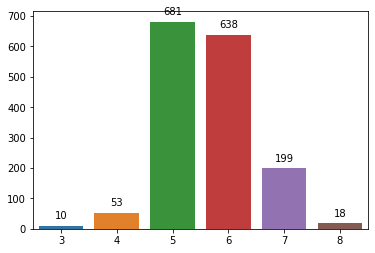

In [9]:
# Checking the data records for each signal strength class
splot = sns.barplot(signals['Signal_Strength'].value_counts().index, signals['Signal_Strength'].value_counts().values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


#### Inference:
* Data records for class 3,4 and 18 are  very less. Hence model will be weak in analysng and classify these signal strength classes.
* We have to use resampling to manage imbalance classification issue.

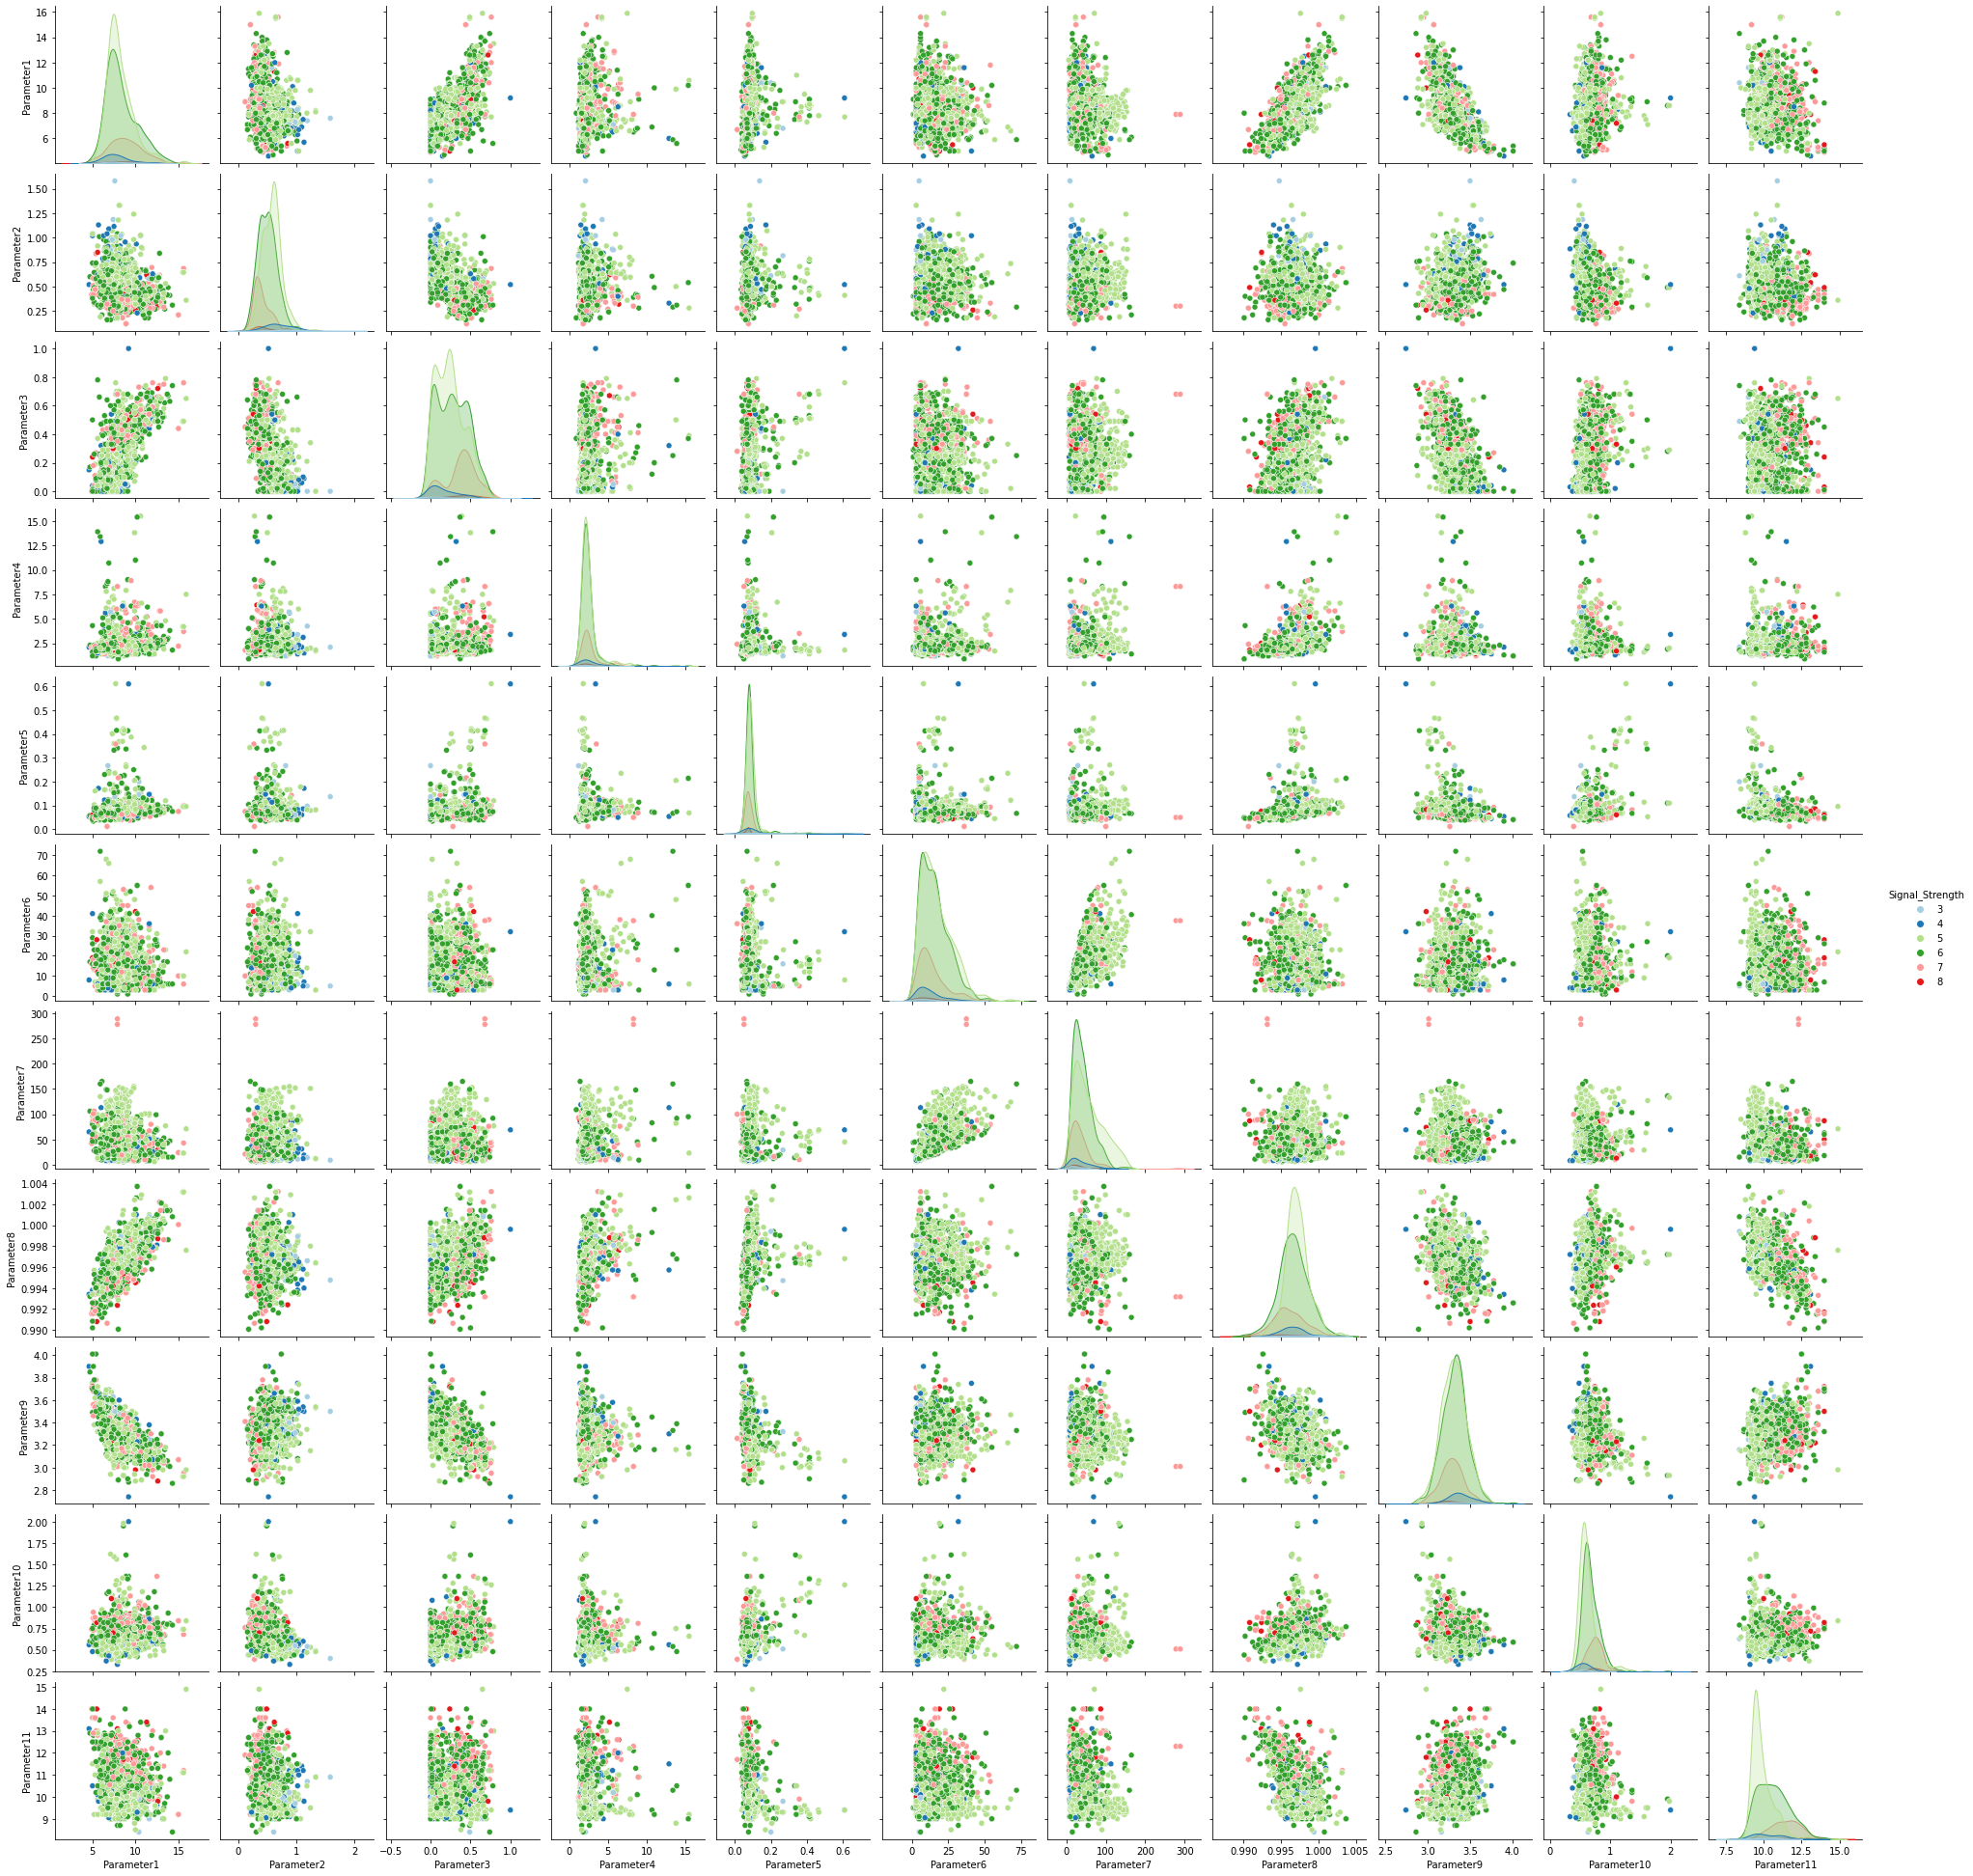

In [10]:
sns.pairplot(signals,diag_kind = 'kde', hue = 'Signal_Strength',palette = 'Paired') 
plt.show()

#### Inference
 * With pairplot we can see that not a single feature can clearly able to classsify the signal strength.
 * Which features are important is also difficult to say using only pair plot.

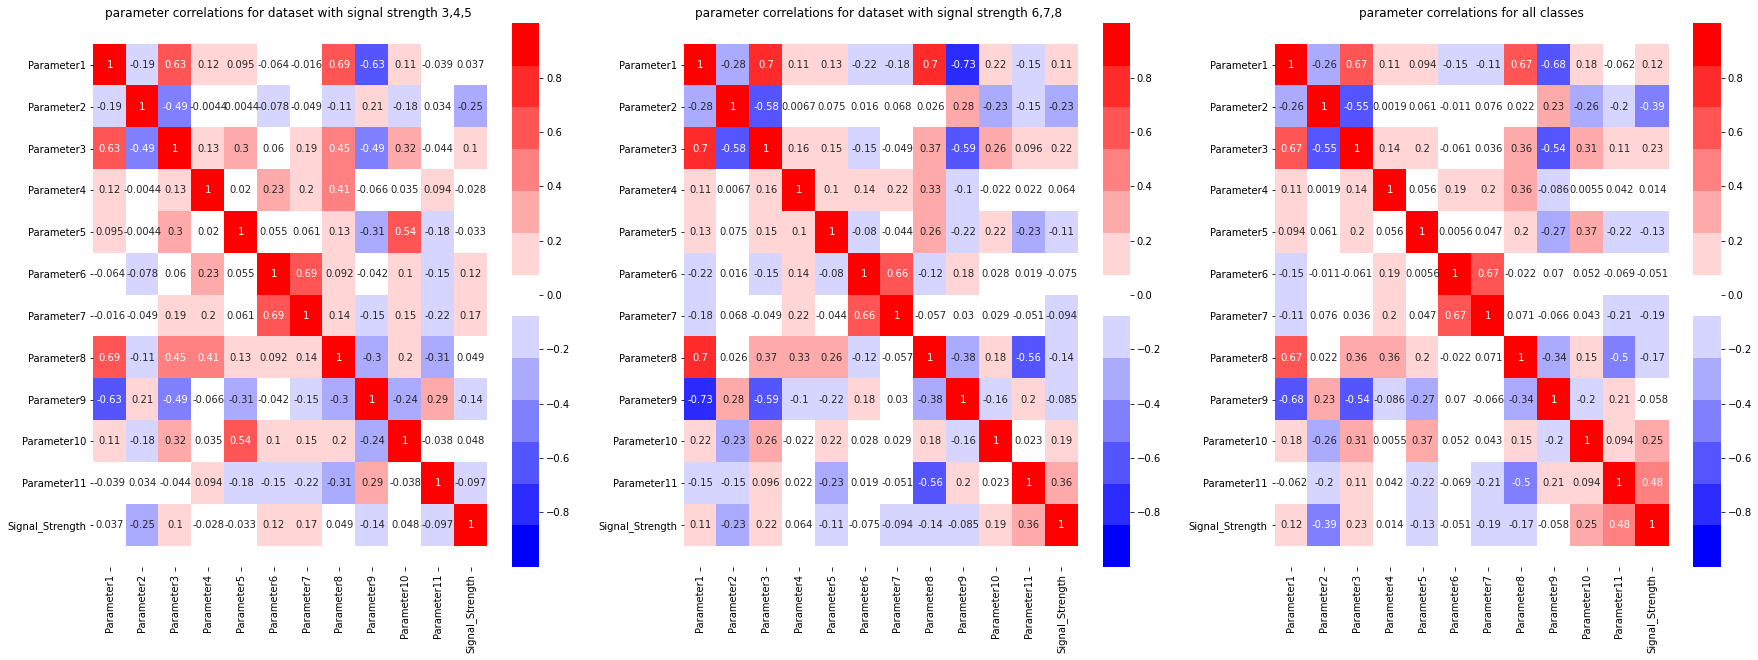

In [11]:
# Checking the correlation map of all the features with the signal strength
n_colors = 13
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

fig = plt.figure( figsize=(30, 10))

#plt.title('parameter correlations')
plt.subplot(1,3,1)
plt.title('parameter correlations for dataset with signal strength 3,4,5 ')
h_map = sns.heatmap(signals[signals['Signal_Strength'] < 6].corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(signals.columns),
                    yticklabels=list(signals.columns))
plt.xticks(rotation=90) 

cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)
plt.subplot(1,3,2)
plt.title('parameter correlations for dataset with signal strength 6,7,8 ')
h_map = sns.heatmap(signals[signals['Signal_Strength'] > 5].corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(signals.columns),
                    yticklabels=list(signals.columns))
plt.xticks(rotation=90) 

cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

plt.subplot(1,3,3)
plt.title('parameter correlations for all classes')
h_map = sns.heatmap(signals.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(signals.columns),
                    yticklabels=list(signals.columns))
plt.xticks(rotation=90) 

cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Inference:
* The correlation is less than 0.5 for all features with the target column Signals Strength.
* Need to check other ways to find good features. Will use random forest for feature importance.

### Split Data to feature set X and Target column y.

In [12]:
# Target column transformed to categorical using one hot encoding LE.
from sklearn.preprocessing import LabelEncoder
import copy
signals_n = copy.deepcopy(signals) 
lb_make = LabelEncoder()
signals_n.loc[:,['Signal_Strength']] = signals_n.loc[:,['Signal_Strength']].apply(lb_make.fit_transform)
X= signals_n.drop('Signal_Strength', axis = 1) #independent features
y= signals_n['Signal_Strength'] 


In [13]:
# Addressing the imbalance issue using SVM SMOTE sampling method
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE( random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Shape of new feature data set (X_res)', X_res.shape[0], 'rows and 11 feature columns')
print('Shape of target label data set (y_res)', y_res.shape[0], 'rows ')

Shape of new feature data set (X_res) 3260 rows and 11 feature columns
Shape of target label data set (y_res) 3260 rows 


In [14]:
# Checking the target column class distribution of the new resampled data set.
unique_elements, counts_elements = np.unique(y_res, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))


[[  0   1   2   3   4   5]
 [379 367 681 681 681 471]]


In [15]:
# Spliting the new dataset in to training and test dataset.
from sklearn.model_selection import train_test_split
(X_train,X_test,y_train,y_test) = train_test_split(X_res,y_res,test_size = 0.2, random_state = 1)
print('shape of X_train :', X_train.shape)
print('shape of y_train :', y_train.shape)
print('shape of X_test :', X_test.shape)
print('shape of y_test :', y_test.shape)

shape of X_train : (2608, 11)
shape of y_train : (2608,)
shape of X_test : (652, 11)
shape of y_test : (652,)


In [16]:
# Checking type for the new data set split
print (type(X_train))
print (type(X_test))
print (type(y_train))
print (type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
# Checking the distrbution of new data set
pd.DataFrame(X_train).describe().T


,count,mean,std,min,25%,50%,75%,max
0,2608.0,8.374447,1.654584,4.700000,7.175283,8.000000,9.483454,15.900000
1,2608.0,0.552522,0.230823,0.011034,0.374048,0.505203,0.686904,1.577061
2,2608.0,0.277993,0.209168,-0.213204,0.054848,0.290000,0.465030,0.911417
3,2608.0,2.730237,1.292030,0.900000,2.000000,2.393236,2.821523,15.500000
4,2608.0,0.083854,0.034193,0.012000,0.070000,0.078000,0.088978,0.611000
5,2608.0,12.240938,9.654171,1.000000,5.267302,8.000000,16.000000,72.000000
6,2608.0,33.846948,29.942524,6.000000,14.685330,21.855515,44.000000,289.000000
7,2608.0,0.996459,0.001787,0.990070,0.995356,0.996555,0.997480,1.003690
8,2608.0,3.313925,0.150927,2.859282,3.190215,3.317276,3.417381,4.010000
9,2608.0,0.652377,0.153625,0.330000,0.550000,0.630000,0.720000,1.980000


In [18]:
# Normalizing the feature dataset and scaling them between 0 to 1 using standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaledX_train = sc.fit_transform(X_train)
scaledX_test = sc.fit_transform(X_test)

### Finding the feature importance using Random Forest

In [19]:
#Getting the best n_estimator for Random forest algo for this data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# creating odd list of k
myList = list(range(1,100))
# empty list that will hold cv scores
cv_scores = []
n_estimators = []
for k in myList:
    rf = RandomForestClassifier(criterion='entropy', min_samples_leaf =1, bootstrap = True, n_estimators=k)
    scores = cross_val_score(rf, scaledX_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    n_estimators.append(k)
MSE = [1 - x for x in cv_scores]
min(MSE)
MSE.index(min(MSE))
best_k = myList[MSE.index(min(MSE))]
print ("The optimal number of n_estimators is %d" % best_k)

The optimal number of n_estimators is 60


In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(criterion='entropy', min_samples_leaf =1, bootstrap = True, random_state =10, n_estimators=best_k)
rf_clf.fit(scaledX_train, y_train)
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(rf_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
6,Parameter7,0.182
10,Parameter11,0.141
9,Parameter10,0.114
5,Parameter6,0.099
1,Parameter2,0.097
2,Parameter3,0.071
4,Parameter5,0.068
8,Parameter9,0.065
3,Parameter4,0.062
0,Parameter1,0.050


### Inference:
* Finally we get parameter 2, 6, 7, 10 and 11 number column as most important feature that will contribute maximum for classification of target label.

### Neural Network for Classification

In [40]:
y_reg = y_res
y_class = tf.keras.utils.to_categorical(y_res, 6)   # Converting the target into categorical array so that each output neuron will classify one class

In [41]:
#Splitting the data for neural classification
from sklearn.model_selection import train_test_split
(X_train,X_test,y_train,y_test) = train_test_split(X_res,y_class,test_size = 0.2, random_state = 1)

# Normalizing the feature dataset and scaling them between 0 to 1 using standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaledX_train = sc.fit_transform(X_train)
scaledX_test = sc.fit_transform(X_test)

In [42]:
#check shape of training and test data set
print('shape of X_train :', X_train.shape)
print('shape of y_train :', y_train.shape)
print('shape of X_test :', X_test.shape)
print('shape of y_test :', y_test.shape)
# Checking type for the new data set split
print (type(X_train))
print (type(X_test))
print (type(y_train))
print (type(y_test))

shape of X_train : (2608, 11)
shape of y_train : (2608, 6)
shape of X_test : (652, 11)
shape of y_test : (652, 6)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [43]:
wt_init = tf.keras.initializers.he_normal( seed = None) # Weight initialization
Lrelu = tf.keras.layers.LeakyReLU()  # Using activation function as leaky relu

class_model = Sequential()
class_model.add(Dense(9,  activation=Lrelu, input_shape = (11,), kernel_initializer = wt_init) )  # Adding the first hidden layer with 9 neurons for the 11 feature dataset.
class_model.add(Dense(5,  activation='relu')) 
class_model.add(Dense(6, activation='softmax')) # Adding the output layer for classification of 6 classes

for l in class_model.layers:
    print (l.name, l.input_shape,'==>',l.output_shape)
print()
print (class_model.summary())

dense_6 (None, 11) ==> (None, 9)
dense_7 (None, 9) ==> (None, 5)
dense_8 (None, 5) ==> (None, 6)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 9)                 108       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 36        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
batch_size = 32
epochs = 100
lrr = 0.001
opt = tf.keras.optimizers.RMSprop( learning_rate=lrr, momentum=0.1)
#opt = tf.keras.optimizers.Adadelta(learning_rate=lrr, rho=0.95, epsilon=1e-08, name="Adadelta")

class_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = class_model.fit(scaledX_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=True)
validation_accuracy = pd.DataFrame(history.history['val_accuracy']).iloc[(epochs-1),0]




Epoch 1/100
74/74 [==============================] - 1s 4ms/step - loss: 1.8150 - accuracy: 0.1832 - val_loss: 1.6735 - val_accuracy: 0.2989
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 1.6816 - accuracy: 0.2951 - val_loss: 1.5767 - val_accuracy: 0.3870
Epoch 3/100
74/74 [==============================] - 0s 3ms/step - loss: 1.5667 - accuracy: 0.3690 - val_loss: 1.4637 - val_accuracy: 0.4444
Epoch 4/100
74/74 [==============================] - 0s 3ms/step - loss: 1.4482 - accuracy: 0.4350 - val_loss: 1.3508 - val_accuracy: 0.4406
Epoch 5/100
74/74 [==============================] - 0s 3ms/step - loss: 1.3330 - accuracy: 0.4514 - val_loss: 1.2684 - val_accuracy: 0.4444
Epoch 6/100
74/74 [==============================] - 0s 2ms/step - loss: 1.2338 - accuracy: 0.4766 - val_loss: 1.2046 - val_accuracy: 0.4444
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 1.1732 - accuracy: 0.4695 - val_loss: 1.1538 - val_accuracy: 0.4789
Epoch 8/100
7

In [45]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend(['training', 'validation'], loc='best')
  plt.grid(True)

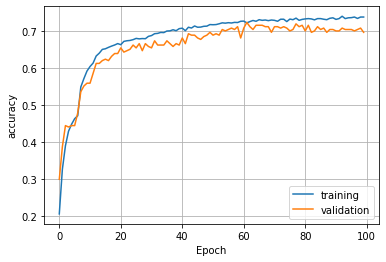

In [46]:
plot_accuracy(history)

[0.29885056614875793, 0.38697317242622375, 0.4444444477558136, 0.4406130313873291, 0.4444444477558136, 0.4444444477558136, 0.4789271950721741, 0.5363984704017639, 0.5517241358757019, 0.5593869686126709, 0.5593869686126709, 0.5862069129943848, 0.6130267977714539, 0.6130267977714539, 0.6206896305084229, 0.6245210766792297, 0.6206896305084229, 0.6321839094161987, 0.6398467421531677, 0.6398467421531677, 0.6551724076271057, 0.6436781883239746, 0.6475095748901367, 0.6513410210609436, 0.6628352403640747, 0.6551724076271057, 0.6666666865348816, 0.6475095748901367, 0.6666666865348816, 0.6590038537979126, 0.6551724076271057, 0.6743295192718506, 0.6628352403640747, 0.6628352403640747, 0.6628352403640747, 0.6743295192718506, 0.6666666865348816, 0.6590038537979126, 0.6666666865348816, 0.6628352403640747, 0.6819923520088196, 0.6666666865348816, 0.6934865713119507, 0.6896551847457886, 0.6896551847457886, 0.6819923520088196, 0.6781609058380127, 0.6858237385749817, 0.6896551847457886, 0.697318017482757

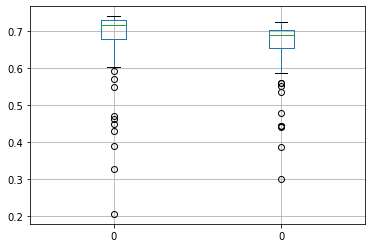

In [47]:
import pandas as pd

print(history.history['val_accuracy'])

print(history.history['accuracy'])

ta = pd.DataFrame(history.history['accuracy'])
va = pd.DataFrame(history.history['val_accuracy'])

tva = pd.concat([ta,va] , axis=1)

tva.boxplot()

In [48]:
loss,accuracy  = class_model.evaluate(scaledX_test, y_test, verbose=False)
print("model accuracy % on validation data set: ", validation_accuracy*100)
print("model accuracy % on test data set :" , accuracy*100)


model accuracy % on validation data set:  69.73180174827576
model accuracy % on test data set : 72.08588719367981


### Neural Network for Regression

In [49]:
from sklearn.model_selection import train_test_split
(X_train,X_test,y_train,y_test) = train_test_split(X_res,y_reg,test_size = 0.2, random_state = 1)
print('shape of X_train :', X_train.shape)
print('shape of y_train :', y_train.shape)
print('shape of X_test :', X_test.shape)
print('shape of y_test :', y_test.shape)

shape of X_train : (2608, 11)
shape of y_train : (2608,)
shape of X_test : (652, 11)
shape of y_test : (652,)


In [50]:
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

In [51]:
wt_init = tf.keras.initializers.he_normal( seed = None) # Weight initialization
Lrelu = tf.keras.layers.LeakyReLU()  # Using activation function as leaky relu

reg_model = Sequential( normalizer)
reg_model.add(Dense(7,  activation=Lrelu, input_shape = (11,), kernel_initializer = wt_init) )  # Adding the first hidden layer with 9 neurons for the 11 feature dataset.
reg_model.add(Dense(4,  activation=Lrelu)) 
reg_model.add(Dense(1, activation='linear')) # Adding the output layer for classification of 6 classes

for l in reg_model.layers:
    print (l.name, l.input_shape,'==>',l.output_shape)
print()
print (reg_model.summary())

normalization_1 (None, None) ==> (None, 11)
dense_9 (None, 11) ==> (None, 7)
dense_10 (None, 7) ==> (None, 4)
dense_11 (None, 4) ==> (None, 1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 11)                23        
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 84        
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 144
Trainable params: 121
Non-trainable params: 23
_________________________________________________________________
None


In [52]:
batch_size = 32
epochs = 50
lrr = 0.001
#opt = tf.keras.optimizers.Adam(learning_rate=lrr)
opt2 = tf.keras.optimizers.RMSprop( learning_rate=lrr, momentum=0.1)
#opt = tf.keras.optimizers.Adadelta(learning_rate=lrr, rho=0.95, epsilon=1e-08, name="Adadelta")

reg_model.compile(optimizer=opt2, loss='mean_absolute_error') 

#history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,callbacks=[callback], validation_split=0.1, verbose=True)
history = reg_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=True)

validation_loss = pd.DataFrame(history.history['val_loss']).iloc[(epochs-1),0]


Epoch 1/50
74/74 [==============================] - 1s 4ms/step - loss: 2.4169 - val_loss: 1.9562
Epoch 2/50
74/74 [==============================] - 0s 2ms/step - loss: 1.7710 - val_loss: 1.3696
Epoch 3/50
74/74 [==============================] - 0s 2ms/step - loss: 1.2847 - val_loss: 1.0308
Epoch 4/50
74/74 [==============================] - 0s 2ms/step - loss: 0.9769 - val_loss: 0.8964
Epoch 5/50
74/74 [==============================] - 0s 2ms/step - loss: 0.8818 - val_loss: 0.8264
Epoch 6/50
74/74 [==============================] - 0s 2ms/step - loss: 0.8021 - val_loss: 0.7707
Epoch 7/50
74/74 [==============================] - 0s 2ms/step - loss: 0.7541 - val_loss: 0.7318
Epoch 8/50
74/74 [==============================] - 0s 2ms/step - loss: 0.7080 - val_loss: 0.6968
Epoch 9/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6809 - val_loss: 0.6678
Epoch 10/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6362 - val_loss: 0.6391
Epoch 11/50
74/74 [

In [53]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)

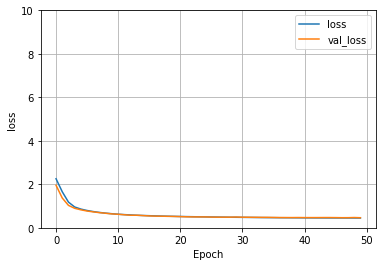

In [54]:
plot_loss(history)

[1.9562389850616455, 1.3695738315582275, 1.030847191810608, 0.8963912725448608, 0.826395571231842, 0.7707263827323914, 0.7317994236946106, 0.6967770457267761, 0.6678354740142822, 0.6391016840934753, 0.6225363612174988, 0.6000972986221313, 0.5775676369667053, 0.5779509544372559, 0.5616351962089539, 0.5464361906051636, 0.5366290807723999, 0.5344799757003784, 0.5271342396736145, 0.5235875248908997, 0.514310359954834, 0.5065276026725769, 0.5012116432189941, 0.500442385673523, 0.5006415247917175, 0.4927937686443329, 0.4892430007457733, 0.4893327057361603, 0.488772451877594, 0.49512338638305664, 0.48640161752700806, 0.4844306707382202, 0.4820728302001953, 0.4799927771091461, 0.4800010323524475, 0.47570812702178955, 0.47135961055755615, 0.4704323410987854, 0.47012999653816223, 0.47215333580970764, 0.46921563148498535, 0.4696379005908966, 0.4693481922149658, 0.47105565667152405, 0.4712309241294861, 0.46832674741744995, 0.46455198526382446, 0.465293824672699, 0.4722602963447571, 0.4633298814296

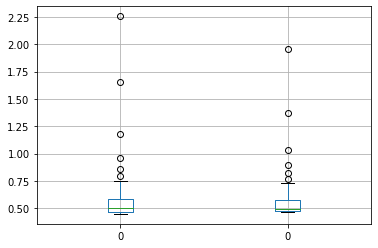

In [55]:
import pandas as pd

print(history.history['val_loss'])

print(history.history['loss'])

ta = pd.DataFrame(history.history['loss'])
va = pd.DataFrame(history.history['val_loss'])

tva = pd.concat([ta,va] , axis=1)

tva.boxplot()

In [67]:
loss = reg_model.evaluate(X_test, y_test, verbose=False)
print("model loss on validation data set: %.2f" %validation_loss)
print("model loss on test data set : %.2f" %loss)



model loss on validation data set: 0.46
model loss on test data set : 0.48


#### Inference
* Data is having lot of noice which is causing the loss to be high during regression.
* This noice can be reduced by clubbing the important features and removing irrelevant features. This could be done with domain understanding of the paramaters 1 to 11 and its relation with signal strength.

### GUI for Neural Network

In [1]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import re
from imblearn.over_sampling import SVMSMOTE

# create a GUI window
gui = tk.Tk() 
 
# set the background colour of GUI window 
gui.configure() 
 
# set the title of GUI window 
gui.title("Neural Networks GUI - Great Learning") 
 
# set the configuration of GUI window 
gui.geometry("750x300") 
    
# Create Labels
ttk.Label(gui,width =35, text = 'Step 1: File Name').grid(row =0, column =0, sticky =tk.W)
ttk.Label(gui,width =35, text = 'Step 2: Target Column').grid(row =1, column =0, sticky=tk.W)
ttk.Label(gui,width =35, text = 'Step 3: Neural Network Regressor').grid(row =3, column =0, sticky=tk.W)
ttk.Label(gui,width =35, text = 'Regression').grid(row =4, column =0, sticky=tk.W)
ttk.Label(gui,width =35, text = 'Pickle').grid(row =5, column =0, sticky=tk.W)
ttk.Label(gui,width =35, text = 'Step 4: Neural Network Classifier').grid(row =7, column =0, sticky=tk.W)
ttk.Label(gui,width =35, text = 'Classifier').grid(row =8, column =0, sticky=tk.W)
    
    
# StringVar() is the variable class 
# we create an instance of this class 
#equation = StringVar() 
NameFile = tk.StringVar() 
NameTarget = tk.StringVar()
    
# create the text entry box for 
# showing the expression . 
NameFile_field = ttk.Entry(gui, width =16, textvariable=NameFile).grid(row=0,column=2)
NameTarget = ttk.Entry(gui, width =16, textvariable=NameTarget).grid(row=1,column=2)


# Define import function for import button
def Import_Data():
    global signals
    DF_Name=NameFile.get()
    #print(DF_Name)
    signals=pd.read_csv(DF_Name)
    confirm = tk.StringVar()
    confirm_entrybox = ttk.Entry(gui, textvariable=confirm,width=16).grid(row =0, column=7)
    confirm.set("Done")
    signals.columns = signals.columns.str.replace(' ', '')
    #print(DB.head())    
# create a Buttons and place at a particular 
button1 = ttk.Button(gui, text=' Import Data ', command=Import_Data) 
button1.grid(row=0, column=4) 

# Define target column fetch function for target column button
def Target_Col():
    target = tk.StringVar()
    target_entrybox = ttk.Entry(gui, textvariable=target, width=16).grid(row =1, column=7)
    target.set("Signal_Strength")
# create a Buttons and place at a particular 
button2 = ttk.Button(gui, text=' Import Target ', command=Target_Col) 
button2.grid(row=1, column=4) 

# Define reggresion train function for train button
def Regr_Train():
    X= signals.drop('Signal_Strength', axis = 1) #independent features
    y= signals['Signal_Strength'] 
    
    
    sm = SVMSMOTE( random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    y_reg = y_res
    
    from sklearn.model_selection import train_test_split
    (X_train,X_test,y_train,y_test) = train_test_split(X_res,y_reg,test_size = 0.2, random_state = 1)
    
    from tensorflow.keras.layers.experimental import preprocessing
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(X_train))
    
    wt_init = tf.keras.initializers.he_normal( seed = None) # Weight initialization
    Lrelu = tf.keras.layers.LeakyReLU()  # Using activation function as leaky relu
    
    reg_model = Sequential( normalizer)
    reg_model.add(Dense(7,  activation=Lrelu, input_shape = (11,), kernel_initializer = wt_init) )  # Adding the first hidden layer with 9 neurons for the 11 feature dataset.
    reg_model.add(Dense(4,  activation=Lrelu)) 
    reg_model.add(Dense(1, activation='linear')) # Adding the output layer for classification of 6 classes
    
    batch_size = 32
    epochs = 50
    lrr = 0.001
    opt2 = tf.keras.optimizers.RMSprop( learning_rate=lrr, momentum=0.1)
    
    reg_model.compile(optimizer=opt2, loss='mean_absolute_error') 
    history = reg_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=False)
    validation_loss = pd.DataFrame(history.history['val_loss']).iloc[(epochs-1),0]
    
    confirmTrain = tk.StringVar()
    confirmTrain_entrybox = ttk.Entry(gui, textvariable=confirmTrain,width=16).grid(row =4, column=7)
    confirmTrain.set("Network Trained for regression")
# create a Buttons and place at a particular 
button3 = ttk.Button(gui, text=' Train ', command=Regr_Train) 
button3.grid(row=4, column=4)

# Define reggresion test evaluation function for test button
def Regr_Test():
    loss = reg_model.evaluate(X_test, y_test, verbose=False)
    
    confirmTest = tk.StringVar()
    confirmTest_entrybox = ttk.Entry(gui, textvariable=confirmTest,width=16).grid(row =5, column=7)
    confirmTest.set("Network Tested with loss" + loss)
    
# create a Buttons and place at a particular    
button4 = ttk.Button(gui, text=' Run ', command=Regr_Test) 
button4.grid(row=5, column=4) 
     
def Classif_Train():
    X= signals_n.drop('Signal_Strength', axis = 1) #independent features
    y= signals_n['Signal_Strength'] 
    
    from imblearn.over_sampling import SVMSMOTE
    sm = SVMSMOTE( random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    y_class = tf.keras.utils.to_categorical(y_res, 6) 
    
    #Splitting the data for neural classification
    from sklearn.model_selection import train_test_split
    (X_train,X_test,y_train,y_test) = train_test_split(X_res,y_class,test_size = 0.2, random_state = 1)
    
    # Normalizing the feature dataset and scaling them between 0 to 1 using standard scaler
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    scaledX_train = sc.fit_transform(X_train)
    scaledX_test = sc.fit_transform(X_test)
    
    wt_init = tf.keras.initializers.he_normal( seed = None) # Weight initialization
    Lrelu = tf.keras.layers.LeakyReLU()  # Using activation function as leaky relu
    
    class_model = Sequential()
    class_model.add(Dense(9,  activation=Lrelu, input_shape = (11,), kernel_initializer = wt_init) )  # Adding the first hidden layer with 9 neurons for the 11 feature dataset.
    class_model.add(Dense(5,  activation='relu')) 
    class_model.add(Dense(6, activation='softmax')) # Adding the output layer for classification of 6 classes

    batch_size = 32
    epochs = 100
    lrr = 0.001
    opt = tf.keras.optimizers.RMSprop( learning_rate=lrr, momentum=0.1)
    
    class_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    history = class_model.fit(scaledX_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=False)
    validation_accuracy = pd.DataFrame(history.history['val_accuracy']).iloc[(epochs-1),0]
    
    classCnfTrain = tk.StringVar()
    classCnfTrain_entrybox = ttk.Entry(gui, textvariable=classCnfTrain,width=16).grid(row =8, column=7)
    classCnfTrain.set("Network Trained for classification" )
# create a Buttons and place at a particular 
button5 = ttk.Button(gui, text=' Train ', command=Classif_Train) 
button5.grid(row=8, column=4) 

def Classif_Test():
    loss,accuracy  = class_model.evaluate(scaledX_test, y_test, verbose=False)
    classCnfTest = tk.StringVar()
    classCnfTest_entrybox = ttk.Entry(gui, textvariable=classCnfTest,width=16).grid(row =9, column=7)
    classCnfTest.set("Network Tested for classification" + accuracy )
# create a Buttons and place at a particular 
button6 = ttk.Button(gui, text=' Run ', command=Classif_Test) 
button6.grid(row=9, column=4) 
 
# start the GUI 
gui.mainloop() 
